# Read Angle-Dependent Fornax Models

Read and plot the HDF5 data from the angle-dependent Fornax 3D supernova simulations. The data were downloaded from https://www.astro.princeton.edu/~burrows/nu-emissions.3d/.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob

import h5py
from astropy.table import Table
from astropy import units as u

import healpy as hp
from scipy.special import gamma, lpmv

mpl.rc('font', size=14)

In [3]:
def get_grid():
    """Read the spherical grid file provided in the Fornax output.
    
    Returns
    -------
    phic : np.array
        Array of central phi values.
    thetac : np.array
        Array of central theta values.
    dOmega : np.array
        Array of solid angles.
    """
    grid_file = h5py.File('data/grid.h5', 'r')
    phic = np.array(grid_file['phic'])
    thetac = np.array(grid_file['thc'])
    dOmega = np.array(grid_file['dOmega'])
    return phic, thetac, dOmega

def get_lum_file(progmass):
    """Get the luminosity file corresponding to a given progenitor mass.
    
    Parameters
    ----------
    progmass : astropy.units.quantity.Quantity
        Progenitor mass, in units of solar mass.
        
    Returns
    -------
    lum_file : str
        Filename with angle-dependent luminosity.
    """

    lum_files = sorted(glob('data/lum_spec*.h5'))
    lum_file = None

    # Find the corresponding file.
    get_mass = lambda filename: float(filename.split('_')[-1][:-4]) * u.M_sun
    for lf in lum_files:
        if progmass == get_mass(lf):
            lum_file = lf
            break

    if lum_file is None:
        raise ValueError('No progenitor with mass {} Msun'.format(progmass.value))
    
    return lum_file

## Real (Tesseral) Spherical Harmonics

$$
Y_{\ell m} =
\begin{cases}
 \displaystyle (-1)^m\sqrt{2} \sqrt{{2\ell+1 \over 4\pi}{(\ell-|m|)!\over (\ell+|m|)!}} \ 
 P_\ell^{|m|}(\cos \theta) \ \sin( |m|\varphi )  
 &\mbox{if } m<0 
 \\
 \displaystyle \sqrt{{ 2\ell+1 \over 4\pi}} \ P_\ell^m(\cos \theta) 
 & \mbox{if } m=0 
 \\
 \displaystyle (-1)^m\sqrt{2} \sqrt{{2\ell+1 \over 4\pi}{(\ell-m)!\over (\ell+m)!}} \ 
 P_\ell^m(\cos \theta) \ \cos( m\varphi )
 & \mbox{if } m>0 \,.
\end{cases}
$$

In [4]:
def fact(n):
    return gamma(n+1)

def real_sph_harm(l, m, phi, theta):
    if m < 0:
        norm = np.sqrt((2*l + 1.)/(2*np.pi)*fact(l + m)/fact(l - m))
        return norm * lpmv(-m, l, np.cos(theta)) * np.sin(-m*phi)
    elif m == 0:
        norm = np.sqrt((2*l + 1.)/(4*np.pi))
        return norm * lpmv(0, l, np.cos(theta))
    else:
        norm = np.sqrt((2*l + 1.)/(2*np.pi)*fact(l - m)/fact(l + m))
        return norm * lpmv(m, l, np.cos(theta)) * np.cos(m*phi)

In [5]:
phic, thetac, dOmega = get_grid()
lum_file = get_lum_file(10 * u.M_sun)
data = h5py.File(lum_file, 'r')

## HDF5 Contents

According to the [Fornax README](https://www.astro.princeton.edu/~burrows/nu-emissions.3d/README.pdf) file, there are three primary data groups per HDF5 file:
1. `nu0`: $\nu_e$ data.
1. `nu1`: $\bar{\nu}_e$ data.
1. `nu2`: $\nu_x$.

Each of these groups contains the following data sets:
* `egroup`: lab-frame neutrino bin energy at each time for each of the 12 neutrino energy bins in MeV.
* `degroup`: lab-frame neutrino bin energy group width at each time for each of the 12 bins.
* `eave`: average neutrino energy (in MeV) over all bins at each time.
* `erms`: RMS neutrino energy (in MeV) over all bins at each time.
* `g0` ... `g11`:  luminosity spectra (in units of $10^{50}$ erg s$^{−1}$ MeV$^{−1}$) in each of the twelve energy bins.

The energy bin width (`degroup`) allows you to calculate the bin-integrated luminosity for the luminosity spectra.

Time bins are given as attributes to the energy-binned luminosities `g0` ... `g11` in the HDF5 files.

In [6]:
time = data['nu0']['g0'].attrs['time']
egrp = data['nu0']['egroup']
data['nu0'].keys()

<KeysViewHDF5 ['degroup', 'eave', 'egroup', 'erms', 'g0', 'g1', 'g10', 'g11', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9']>

In [7]:
nside = 2**4
npix = hp.nside2npix(nside)
th, ph = hp.pix2ang(nside, np.arange(npix))
L0 = np.zeros(npix, dtype=float)

ebin = 5
tbin = 0

for l in range(0,3):
    for m in range(-l, l+1):
        lm = 'l={} m={}'.format(l, m)
        alm = data['nu0']['g{}'.format(ebin)][lm][()][tbin]
        
        L0 += alm * real_sph_harm(l, m, th, ph)
        print(l, m, alm)

0 0 372.74707
1 -1 -4.9031877e-07
1 0 2.5281196e-08
1 1 -4.9523034e-05
2 -2 1.3698863e-07
2 -1 -6.4737215e-08
2 0 0.028897654
2 1 2.3751745e-08
2 2 1.3200333e-05


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


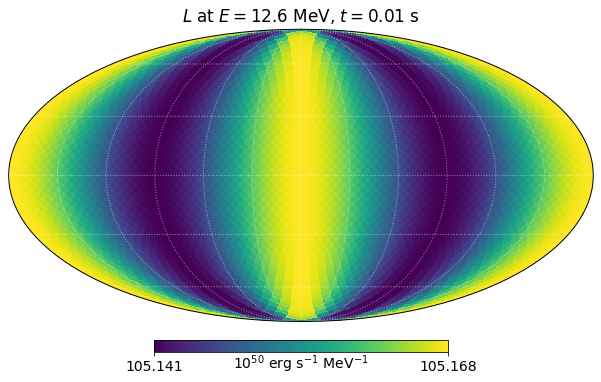

In [8]:
hp.mollview(L0, title='$L$ at $E={:.1f}$ MeV, $t={:g}$ s'.format(egrp[tbin][ebin], time[tbin]),
            unit='$10^{50}$ erg s$^{-1}$ MeV$^{-1}$')
hp.graticule(ls=':', color='w', alpha=0.5)
fig = plt.gcf()
fig.savefig('test.png')

## Time Evolution of $L_0$

Plot the time evolution of the luminosity at a given energy.

In [ ]:
ebin = 5

for tbin in np.arange(0, len(time), 10):
    L0 = np.zeros(npix, dtype=float)

    for l in range(0,3):
        for m in range(-l, l+1):
            lm = 'l={} m={}'.format(l, m)
            alm = data['nu0']['g{}'.format(ebin)][lm][()][tbin]

            L0 += alm * real_sph_harm(l, m, th, ph)
#             print(l, m, alm)
    
    hp.mollview(L0, title='$L$ at $E={:.1f}$ MeV, $t={:g}$ s'.format(egrp[tbin][ebin], time[tbin]),
            unit='$10^{50}$ erg s$^{-1}$ MeV$^{-1}$')
    hp.graticule(ls=':', color='w', alpha=0.5)
    fig = plt.gcf()
    
    output = 'nu0_lum_e{:02d}_t{:03d}.png'.format(ebin, tbin)
    fig.savefig(output)

### Luminosity with respect to Maximum

Plot the luminosity angular distribution with respect to the maximum luminosity *in a given time bin*.

In [ ]:
ebin = 5

for tbin in np.arange(0, len(time), 10):
    L0 = np.zeros(npix, dtype=float)

    for l in range(0,3):
        for m in range(-l, l+1):
            lm = 'l={} m={}'.format(l, m)
            alm = data['nu0']['g{}'.format(ebin)][lm][()][tbin]

            L0 += alm * real_sph_harm(l, m, th, ph)
#             print(l, m, alm)

    Lmin = np.min(L0)
    Lmax = np.max(L0)
    
    hp.mollview(L0/Lmax, min=0.6, max=1.,
                title='$L/L_max$ at $E={:.1f}$ MeV, $t={:g}$ s'.format(egrp[tbin][ebin], time[tbin]))
    hp.graticule(ls=':', color='w', alpha=0.5)
    fig = plt.gcf()
    
    output = 'nu0_lum_e{:02d}_t{:03d}_norm.png'.format(ebin, tbin)
    fig.savefig(output)